In [1]:
import numpy as np 
import pandas as pd 
import os

for dirname, _, filenames in os.walk(''):
    for filename in filenames:
        os.path.join(dirname, filename)

In [2]:
import keras
import tensorflow as tf
from tensorflow.python.client import device_lib

gpus = tf.config.list_physical_devices('GPU')
for gpu in gpus:
    print("Name:", gpu.name, "  Type:", gpu.device_type)
#Gpu check


Name: /physical_device:GPU:0   Type: GPU


In [3]:
import matplotlib.pyplot as plt 
from PIL import Image

In [4]:
dir = 'C:/Users/alexm/Desktop/X-ray/chest_xray'
test_dir = os.path.join(dir+'/','test') 
train_dir =os.path.join(dir+'/','train') 
val_dir =os.path.join(dir+'/','val')

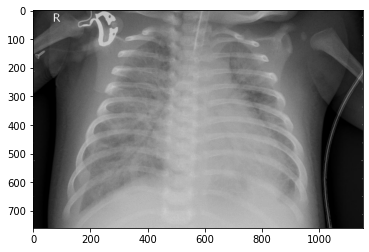

In [5]:
categ = ['NORMAL', 'PNEUMONIA']
for ca in categ:
    path = os.path.join(train_dir + '/',ca)
    for img in os.listdir(path):
        img_arr =Image.open(os.path.join(path+'/',img)) 
        arr = np.array(img_arr)
        plt.imshow(np.array(img_arr),cmap='gray')
        break
        #read data

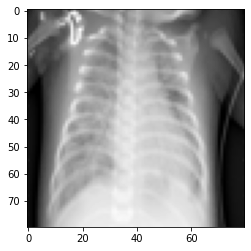

In [6]:
img_size = 80
new_img = img_arr.resize((img_size,img_size))
plt.imshow(new_img,cmap='gray')
plt.show()
#resize to 80x80

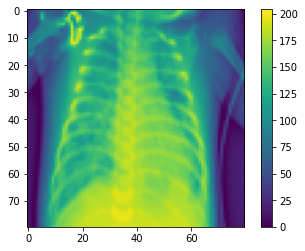

In [7]:
plt.figure()
plt.imshow(new_img)
plt.colorbar()
plt.grid(False)
#pixels from 0 to 255

(1317, 1857)


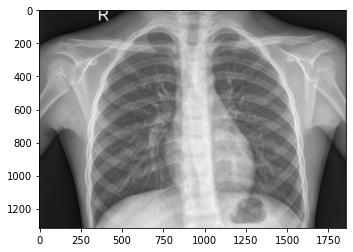

In [8]:
for ca in categ:
    path = os.path.join(test_dir+'/',ca)
    for img in os.listdir(path):
        img_arr =Image.open(os.path.join(path+'/',img)) 
        print(np.array(img_arr).shape)
        plt.imshow(img_arr,cmap='gray')
        plt.show()
        break
    break

In [9]:
def creat_data(my_list,categ,my_dir):
    img_size = 80
    for ca in categ:
        path = os.path.join(my_dir+'/',ca)
        class_num = categ.index(ca)
        for img in os.listdir(path):
            try:
                img_arr =Image.open(os.path.join(path+'/',img)) 
                new_img = img_arr.resize((img_size,img_size))
                new_img = np.asarray(new_img)
                arr = new_img.reshape((img_size, img_size, 1))
                my_list.append([arr,class_num])
            except Exception as e:
                e = e

In [10]:
train_list = []
test_list = []
val_list = []
creat_data(train_list,categ,train_dir)
print(len(train_list))

4933


In [11]:
creat_data(test_list,categ,test_dir)
print(len(test_list))

624


In [12]:
creat_data(val_list,categ,val_dir)
print(len(val_list))

199


In [13]:
for i in range(408):
    val_list.append(train_list.pop(0))

In [14]:
print(len(train_list))
print(len(val_list))
#make val bigger

4525
607


In [15]:
def split_data(X,y,my_list):
    img_size = 80
    for fe,la in my_list:
        X.append(fe)
        y.append(la)
    X = np.array(X).reshape(-1, img_size, img_size, 1)
    #split in x,y

In [16]:
X_train = []
y_train = []
X_test = []
y_test = []
X_val = []
y_val = []
split_data(X_train, y_train, train_list)

In [17]:
split_data(X_test, y_test, test_list)

In [18]:
split_data(X_val, y_val, val_list)

In [19]:
X_train = np.asarray(X_train)
y_train = np.asarray(y_train)
X_test = np.asarray(X_test)
y_test = np.asarray(y_test)
X_val = np.asarray(X_val)
y_val = np.asarray(y_val)

In [20]:
X_train = X_train/255.0
X_test = X_test/255.0
X_val = X_val/255.0

In [21]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D

In [22]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor = 'val_loss', patience = 10, restore_best_weights=True)
#stop if no improving in p epoch

In [23]:
print(X_train.shape)

(4525, 80, 80, 1)


In [24]:
import keras
import numpy as np
import sklearn.model_selection
from keras import layers

inputs = keras.Input(shape=(80, 80, 1))

print(inputs)

# data augmentation
x = tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal')(inputs)
x = tf.keras.layers.experimental.preprocessing.RandomTranslation(height_factor=0.10, width_factor=0.10)(x)
x = tf.keras.layers.experimental.preprocessing.RandomRotation(factor=0.03)(x)

def res_net_block(input_data, filters, conv_size):
    x = layers.Conv2D(filters, conv_size, activation='relu', padding='same')(input_data)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(filters, conv_size, activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Add()([x, input_data])
    return x

# model itself
x = keras.layers.Conv2D(filters=16, kernel_size=3, input_shape=(80, 80, 1), padding='same', activation="relu")(x)
x = keras.layers.Conv2D(filters=8, kernel_size=3, input_shape=(64, 64, 1), padding='same', activation="relu")(x)
num_res_net_blocks = 10
for i in range(num_res_net_blocks):
    x = res_net_block(x, 8, 5)
x = layers.Dropout(0.5)(x)
for i in range(num_res_net_blocks):
    x = res_net_block(x, 8, 5)
x = layers.Conv2D(25, 3, activation='relu')(x)
x = layers.GlobalMaxPooling2D()(x)
x = keras.layers.Dense(256, activation='sigmoid')(x)
x = keras.layers.Dense(16, activation='sigmoid')(x)

outputs = layers.Dense(1, activation='sigmoid')(x)

model = keras.Model(inputs, outputs)
model.compile(loss='binary_crossentropy',
              optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001),
              metrics=['Accuracy','Recall'])
model.summary()
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test,y_test), callbacks=[early_stop])

KerasTensor(type_spec=TensorSpec(shape=(None, 80, 80, 1), dtype=tf.float32, name='input_1'), name='input_1', description="created by layer 'input_1'")
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 80, 80, 1)]  0           []                               
                                                                                                  
 random_flip (RandomFlip)       (None, 80, 80, 1)    0           ['input_1[0][0]']                
                                                                                                  
 random_translation (RandomTran  (None, 80, 80, 1)   0           ['random_flip[0][0]']            
 slation)                                                                                         
                                          

 conv2d_12 (Conv2D)             (None, 80, 80, 8)    1608        ['add_4[0][0]']                  
                                                                                                  
 batch_normalization_10 (BatchN  (None, 80, 80, 8)   32          ['conv2d_12[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 conv2d_13 (Conv2D)             (None, 80, 80, 8)    1608        ['batch_normalization_10[0][0]'] 
                                                                                                  
 batch_normalization_11 (BatchN  (None, 80, 80, 8)   32          ['conv2d_13[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 add_5 (Ad

 ormalization)                                                                                    
                                                                                                  
 conv2d_25 (Conv2D)             (None, 80, 80, 8)    1608        ['batch_normalization_22[0][0]'] 
                                                                                                  
 batch_normalization_23 (BatchN  (None, 80, 80, 8)   32          ['conv2d_25[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 add_11 (Add)                   (None, 80, 80, 8)    0           ['batch_normalization_23[0][0]', 
                                                                  'add_10[0][0]']                 
                                                                                                  
 conv2d_26

 ormalization)                                                                                    
                                                                                                  
 add_17 (Add)                   (None, 80, 80, 8)    0           ['batch_normalization_35[0][0]', 
                                                                  'add_16[0][0]']                 
                                                                                                  
 conv2d_38 (Conv2D)             (None, 80, 80, 8)    1608        ['add_17[0][0]']                 
                                                                                                  
 batch_normalization_36 (BatchN  (None, 80, 80, 8)   32          ['conv2d_38[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 conv2d_39

In [25]:
score = model.evaluate(X_train, y_train)

print(score)

142/142 [==============================] - 4s 25ms/step - loss: 0.1482 - Accuracy: 0.9503 - recall: 0.9649
[0.14817459881305695, 0.950276255607605, 0.9649220705032349]


In [26]:
score = model.evaluate(X_test, y_test)

print(score)

20/20 [==============================] - 1s 25ms/step - loss: 0.6230 - Accuracy: 0.7644 - recall: 0.9795
[0.6229913830757141, 0.7644230723381042, 0.9794871807098389]


Text(0.5, 1.0, 'Acc Evolution')

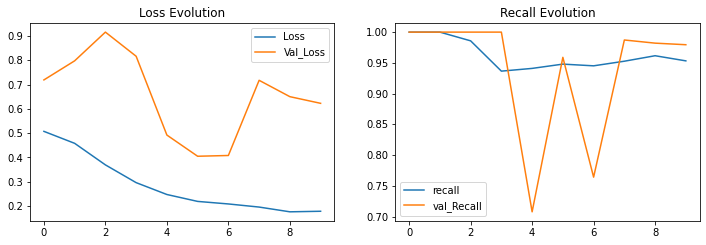

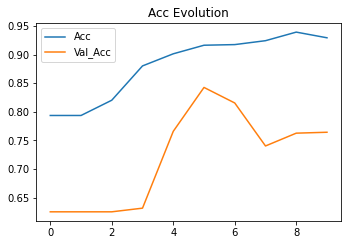

In [27]:
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Val_Loss')
plt.legend()
plt.title('Loss Evolution')

plt.subplot(2, 2, 2)
plt.plot(history.history['recall'], label='recall')
plt.plot(history.history['val_recall'], label='val_Recall')
plt.legend()
plt.title('Recall Evolution')

plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 3)
plt.plot(history.history['Accuracy'], label='Acc')
plt.plot(history.history['val_Accuracy'], label='Val_Acc')
plt.legend()
plt.title('Acc Evolution')